# Eksploracyjna analiza danych dotyczących poziomu szczęścia

In [1]:
import os

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

### Wczytanie danych i wstępna obróbka
W plikach wejściowych wiele nazw kolumn się nie zgadza pomiędzy plikami, a innych brakuje, więc w celu ułatwienia dalszej analizy należy coś z tym zrobić

In [2]:
# Wczytanie wszystkich ramek na raz
dfs = [pd.read_csv(f'data/{filename}') for filename in os.listdir('data')]

In [3]:
# Wybranie potrzebnych kolumn i nazwanie ich tak, żeby ramki były konkatenowalne
df_2015 = dfs[0][['Country', 'Region', 'Happiness Rank', 'Happiness Score', 'Economy (GDP per Capita)', 'Family', 'Freedom']]
df_2016 = dfs[1][['Country', 'Region', 'Happiness Rank', 'Happiness Score', 'Economy (GDP per Capita)', 'Family', 'Freedom']]
df_2017 = dfs[2][['Country', 'Happiness.Rank', 'Happiness.Score', 'Economy..GDP.per.Capita.', 'Family', 'Freedom']]
df_2017 = df_2017.rename(columns = {'Happiness.Rank': 'Happiness Rank', 'Happiness.Score': 'Happiness Score', 'Economy..GDP.per.Capita.': 'Economy (GDP per Capita)'})
df_2018 = dfs[3][['Country or region', 'Score', 'GDP per capita', 'Freedom to make life choices']]
df_2018 = df_2018.rename(columns= {'Country or region': 'Country', 'Score': 'Happiness Score', 'GDP per capita': 'Economy (GDP per Capita)', 'Freedom to make life choices': 'Freedom'})
df_2019 = dfs[4][['Country or region', 'Score', 'GDP per capita', 'Freedom to make life choices']]
df_2019 = df_2019.rename(columns= {'Country or region': 'Country', 'Score': 'Happiness Score', 'GDP per capita': 'Economy (GDP per Capita)', 'Freedom to make life choices': 'Freedom'})

In [4]:
# Dodanie regionu do ramek, w których go nie ma
countries_regions = df_2015[['Country', 'Region']]
df_2017 = df_2017.merge(countries_regions)
df_2018 = df_2018.merge(countries_regions)
df_2019 = df_2019.merge(countries_regions)

In [209]:
# Dodanie kolumny z rokiem
df_2015 = df_2015.assign(year = 2015)
df_2016 = df_2016.assign(year = 2016)
df_2017 = df_2017.assign(year = 2017)
df_2018 = df_2018.assign(year = 2018)
df_2019 = df_2019.assign(year = 2019)

In [210]:
# Połączenie wszystkiego w jedną dużą ramkę
dfs = [df_2015, df_2016, df_2017, df_2018, df_2019]
data = pd.concat(dfs).reset_index(drop = True)

In [211]:
data['Region'].unique()

array(['Western Europe', 'North America', 'Australia and New Zealand',
       'Middle East and Northern Africa', 'Latin America and Caribbean',
       'Southeastern Asia', 'Central and Eastern Europe', 'Eastern Asia',
       'Sub-Saharan Africa', 'Southern Asia'], dtype=object)

In [212]:
# Utworzenie kolumny z kontynentem
region_to_continent_mapping = {'Western Europe': 'Europe', 'North America': 'North America', 'Australia and New Zealand': 'Australia',
                               'Middle East and Northern Africa': 'Africa', 'Latin America and Caribbean': 'South America',
                               'Southeastern Asia': 'Asia', 'Central and Eastern Europe': 'Europe', 'Eastern Asia': 'Asia', 
                               'Sub-Saharan Africa': 'Africa', 'Southern Asia': 'Asia'}
data = data.assign(
    Continent = list(map(lambda r: region_to_continent_mapping[r], data['Region']))
)

In [213]:
data.columns

Index(['Country', 'Region', 'Happiness Rank', 'Happiness Score',
       'Economy (GDP per Capita)', 'Family', 'Freedom', 'year', 'Continent'],
      dtype='object')

### Co ma większy wpływ na szczęscie: rodzina, czy pieniądze?

In [214]:
data_to_plot = data[['Happiness Score', 'Economy (GDP per Capita)', 'Family', 'Region', 'Continent']].dropna()

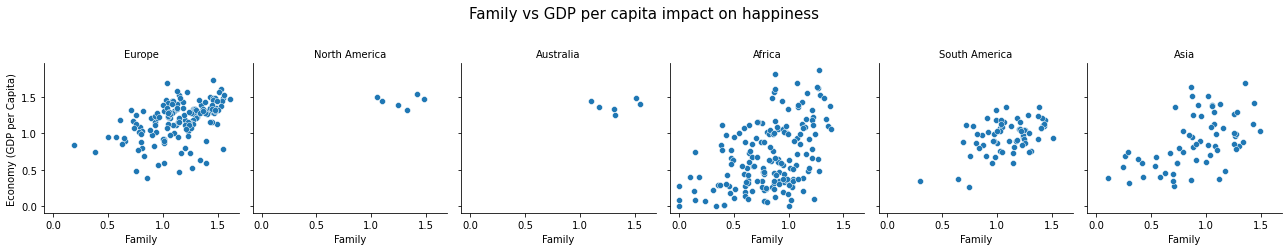

In [215]:
g = sns.FacetGrid(data_to_plot, col='Continent')
g.map(sns.scatterplot, 'Family', 'Economy (GDP per Capita)')
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.fig.suptitle('Family vs GDP per capita impact on happiness', y = 1.15, size = 15);

Odpowiedź na powyższe pytanie brzmi: To zależy na którym kontynencie. Widać, że w Afryce, Azji i Ameryce Południowej dużo większy wpływ na szczęście ma zdecydowanie rodzina, zaś na pozostałych kontynentach jest to rozłożone w miarę równomiernie. Może to wynikać z faktu, że na tych kontynentach rola rodziny jest dużo głębiej zakorzeniona w kulturze niż na innych, albo może też wynikać z tego, że te kontynenty są po prostu biedniejsze i w związku z tym ludzie bardziej doceniają swoje rodziny.

### Gdzie ludzie są najszczęśliwsi?

In [216]:
data['Happiness Score'].describe()

count    763.000000
mean       5.387557
std        1.129230
min        2.693000
25%        4.508500
50%        5.324000
75%        6.208500
max        7.769000
Name: Happiness Score, dtype: float64

In [217]:
data_to_plot = data.assign(
    discretized_happiness = pd.cut(data['Happiness Score'],
        bins = [2.69, 5.32, 6.21, 7.7],
        labels = ['Unhappy', 'Moderate happy', 'Happy']
    )
)

In [218]:
data_to_plot = data_to_plot[['discretized_happiness', 'Continent']]

In [219]:
data_to_plot = pd.concat([data_to_plot['Continent'], 
     pd.get_dummies(data_to_plot['discretized_happiness'])], axis = 1)

In [220]:
data_to_plot = data_to_plot.groupby('Continent').sum(['Happy', 'Moderate happy', 'Unhappy'])
data_to_plot = data_to_plot.apply(
    lambda r: r/r.sum(),
    axis = 1
)

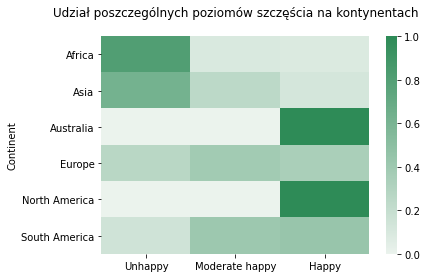

In [221]:
sns.heatmap(data_to_plot, cmap=sns.light_palette("seagreen", as_cmap=True))
plt.title('Udział poszczególnych poziomów szczęścia na kontynentach', pad=20);

Z wizualizacji wynika jednoznacznie, że ludzie są zdecydowanie najszczęśliwsi w Australii i Ameryce Północnej. Z kolei najmniej szczęścliwi są ludzie zamieszkujący Afrykę.

### Jak się zmienia poziom szczęścia w Polsce w zestawieniu z średnią światową?

In [222]:
poland_data = data.query("Country == 'Poland'")[['year', 'Happiness Score']]
poland_data = poland_data.assign(year = poland_data['year'].astype(str))

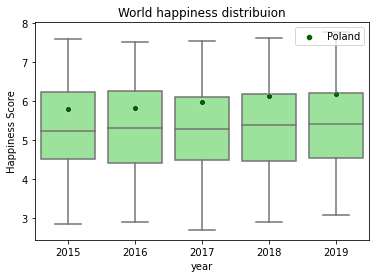

In [223]:
sns.boxplot(data = data, x = 'year', y = 'Happiness Score', color = 'lightgreen')
sns.scatterplot(data = poland_data, x = 'year', y = 'Happiness Score', color = 'darkgreen', label = 'Poland')
plt.legend(loc = 'upper right')
plt.title('World happiness distribuion');

Światowy rozkład szczęścia nie zmienia się w znaczący sposób, ale warto zauważyć, że w Polsce jest wyraźnie widoczny rosnący trend, co oznacza, że Polacy są coraz szczęśliwsi.

### Czy zawsze wolni ludzie są szczęśliwi

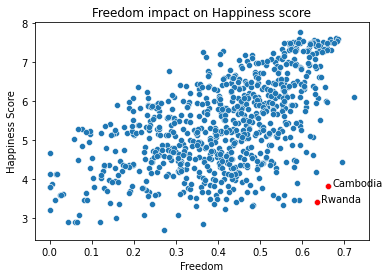

In [225]:
sns.scatterplot(data = data, x = 'Freedom', y = 'Happiness Score')
filtered_freedom_happiness = data[np.logical_and(data['Freedom'] > .6, data['Happiness Score'] < 4)]
filtered_freedom_happiness
sns.scatterplot(data = filtered_freedom_happiness, x = 'Freedom', y = 'Happiness Score', color = 'red')
#plt.text(x = filtered_freedom_happiness['Freedom'].values, y = filtered_freedom_happiness['Happiness Score'].values, s = filtered_freedom_happiness['Country'].values)
for index, row in filtered_freedom_happiness.iterrows():
    plt.text(x = row['Freedom'] + .01, y = row['Happiness Score'], s = row['Country'])
plt.title('Freedom impact on Happiness score');

Jak widać nie zawsze. W niektórych państwach wysoki wpływ wolności na poziom szczęścia nie oznacza, że współczynnik szczęścia jest wysoki. Warto jednak zauważyć, że nie ma krajów o bardzo wysokim poziomie szczęscia (>7), które by miały niski udział wolności. 